*   Nama : **Virgiawan Teguh Kusuma**
*   Email : **181240000833@unisnu.ac.id**
*   Domisili : **Kabupaten Jepara, Jawa Tengah**

In [ ]:
# import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# load dataset dan buat dataframe
dataframe = pd.read_csv('raw_sales.csv')

# melihat data
dataframe

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2


In [ ]:
# drop kolom postcode dan bedrooms
dataframe = dataframe.drop(columns=['postcode', 'bedrooms'])

In [ ]:
# filter baris dengan nilai atribut propertyType = "unit"
dataframe = dataframe.loc[dataframe['propertyType'] == 'unit']

In [ ]:
# melihat hasil data yang telah difilter
dataframe

,datesold,price,propertyType
24552,2007-06-27 00:00:00,300000,unit
24553,2007-07-05 00:00:00,300000,unit
24554,2007-07-19 00:00:00,480000,unit
24555,2007-07-20 00:00:00,360000,unit
24556,2007-08-07 00:00:00,385000,unit
...,...,...,...
29575,2019-07-25 00:00:00,500000,unit
29576,2019-07-25 00:00:00,560000,unit
29577,2019-07-26 00:00:00,464950,unit
29578,2019-07-26 00:00:00,589000,unit


In [ ]:
# drop kolom propertyType karena sudah tidak terpakai dan inisialisasi var baru
newDataframe = dataframe.drop(columns=['propertyType'])
newDataframe

,datesold,price
24552,2007-06-27 00:00:00,300000
24553,2007-07-05 00:00:00,300000
24554,2007-07-19 00:00:00,480000
24555,2007-07-20 00:00:00,360000
24556,2007-08-07 00:00:00,385000
...,...,...
29575,2019-07-25 00:00:00,500000
29576,2019-07-25 00:00:00,560000
29577,2019-07-26 00:00:00,464950
29578,2019-07-26 00:00:00,589000


In [ ]:
# cek apa ada value yang hilang
dataframe.isnull().sum()

datesold        0
price           0
propertyType    0
dtype: int64

In [ ]:
# cek minimum mae
minimumMae = (newDataframe['price'].max() - newDataframe['price'].min()) * 10/100
minimumMae

241500.0

In [ ]:
# normalization dengan minmaxscaler
minmaxscaler = MinMaxScaler(feature_range = (0,1))
scaled = minmaxscaler.fit_transform(newDataframe[['price']])
newDataframe[['price']] = scaled

In [ ]:
# mengubah ke bentuk numpy array
date = newDataframe['datesold'].values
price  = newDataframe['price'].values

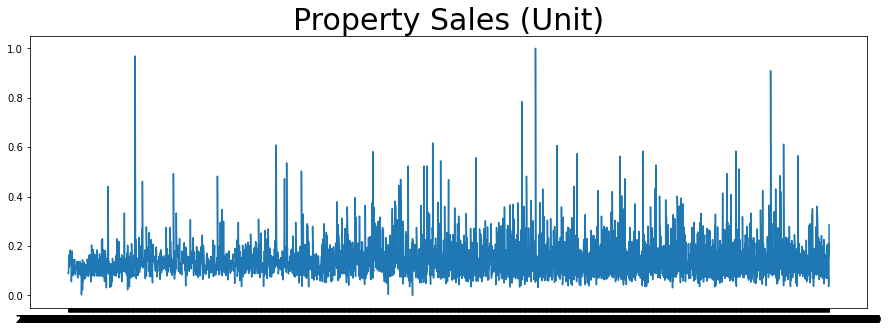

In [ ]:
# viisualisasi data
plt.figure(figsize=(15,5))
plt.plot(date, price)
plt.title('Property Sales (Unit)', fontsize=30);

In [ ]:
# split data training dan testing pada newDataframe
newDataframeTrain, newDataframeTest = train_test_split(newDataframe, test_size=0.2, shuffle=False)
newDataframeTrain, newDataframeVal = train_test_split(newDataframeTrain, test_size=0.2, shuffle=False)

In [ ]:
# inisialisasi
dateTrain = newDataframeTrain['datesold']
dateVal = newDataframeVal['datesold']
dateTest = newDataframeTest['datesold']
priceTrain = newDataframeTrain['price']
priceVal = newDataframeVal['price']
priceTest = newDataframeTest['price']

In [ ]:
# split data training dan testing pada date dan price
dateTrain, dateTest, priceTrain, priceTest = train_test_split(date, price, test_size=0.2, shuffle=False)
dateTrain, dateVal, priceTrain, priceVal = train_test_split(dateTrain, priceTrain, test_size=0.2, shuffle=False)

In [ ]:
# menerima attribute yg sudah diconvert ke numpy array serta return ke bentuk batch
def datasetWindowed(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
# model sequential
trainSet = datasetWindowed(priceTrain, window_size=60, batch_size=128, shuffle_buffer=1000)
valSet = datasetWindowed(priceVal, window_size=60, batch_size=128, shuffle_buffer=1000)
testSet = datasetWindowed(priceTest, window_size=60, batch_size=128, shuffle_buffer=1000)
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
                                    ])

In [ ]:
# menggunakan loss Huber, optimizer SGD dengan learning rate 1.0000e-02 dan momentum 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9)

# compile
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [ ]:
# menggunakan callback agar pengujian berhenti jika mae mencapai target
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# train model dengan fit
model.fit(trainSet, validation_data=valSet, epochs=100,callbacks=[callback])

Epoch 1/100
25/25 [==============================] - 9s 189ms/step - loss: 0.0055 - mae: 0.0808 - val_loss: 0.0019 - val_mae: 0.0464
Epoch 2/100
25/25 [==============================] - 4s 151ms/step - loss: 0.0027 - mae: 0.0477 - val_loss: 0.0018 - val_mae: 0.0462
Epoch 3/100
25/25 [==============================] - 4s 150ms/step - loss: 0.0026 - mae: 0.0474 - val_loss: 0.0018 - val_mae: 0.0432
Epoch 4/100
25/25 [==============================] - 4s 149ms/step - loss: 0.0025 - mae: 0.0469 - val_loss: 0.0018 - val_mae: 0.0429
Epoch 5/100
25/25 [==============================] - 4s 150ms/step - loss: 0.0025 - mae: 0.0467 - val_loss: 0.0018 - val_mae: 0.0430
Epoch 6/100
25/25 [==============================] - 4s 150ms/step - loss: 0.0025 - mae: 0.0464 - val_loss: 0.0018 - val_mae: 0.0434
Epoch 7/100
25/25 [==============================] - 4s 149ms/step - loss: 0.0025 - mae: 0.0464 - val_loss: 0.0018 - val_mae: 0.0430
Epoch 8/100
25/25 [==============================] - 4s 151ms/step - 